
# Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

[//]: # (Image References)

[image1]: ./examples/board_undist.png "Undistorted"
[image2]: ./test_images/test1.jpg "Road Transformed"
[image2-1]: ./examples/test1_undist.jpg "Road Transformed"
[image3]: ./examples/orig_to_thresh.png "Binary Example"
[image4]: ./examples/warped_test.png "Warp Test"
[image4-1]: ./examples/orig_to_warped.png "Warp Example"
[image5]: ./examples/conv_boxes.png "Fit Visual"
[image5-1]: ./examples/conv_lanes.png "Fit Visual"
[image6]: ./examples/lanes_plus_curv.png "Output"
[video1]: ./output_video.mp4 "Video"

## [Rubric](https://review.udacity.com/#!/rubrics/571/view) Points
### Here I will consider the rubric points individually and describe how I addressed each point in my implementation.  

---

### Camera Calibration

#### 1. Briefly state how you computed the camera matrix and distortion coefficients. Provide an example of a distortion corrected calibration image.

The code for this step is contained below in code cells #2-3.

1. I start by preparing "object points", which will be the (x, y, z) coordinates of the chessboard corners in the world. Here I am assuming the chessboard is fixed on the (x, y) plane at z=0, such that the object points are the same for each calibration image.  
- Thus, `objp` is just a replicated array of coordinates, and `objpoints` will be appended with a copy of it every time I successfully detect all chessboard corners in a test image.  
- `imgpoints` will be appended with the (x, y) pixel position of each of the corners in the image plane with each successful chessboard detection.  

2. I then used the output `objpoints` and `imgpoints` to compute the camera calibration and distortion coefficients using the `cv2.calibrateCamera()` function.  I applied this distortion correction to the test image using the `cv2.undistort()` function and obtained this result: 

![alt text][image1]

### Pipeline (single images)

#### 1. Provide an example of a distortion-corrected image.
To demonstrate this step, we can apply the distortion correction to one of the test images like this:

| Original    | Undistorted  | 
|:-----------:|:-------------:|
| ![][image2] | ![][image2-1] |


#### 2. Describe how (and identify where in your code) you used color transforms, gradients or other methods to create a thresholded binary image.  Provide an example of a binary image result.
I used a combination of color and gradient thresholds to generate a binary image (thresholding steps in code cells #24-25).  

Here's an example:

![alt text][image3]

#### 3. Describe how (and identify where in your code) you performed a perspective transform and provide an example of a transformed image.

The code for the perspective transform appears in code cell #26-27.

The warping of images requires inputs for a source (`src`) and destination (`dst`) points.  The source and destination points are hardcoded in the following manner:

```
src = np.float32([
        [img_size[0]*(.5-mid_width/2), img_size[1]*height_pct],  # top left
        [img_size[0]*(.5+mid_width/2), img_size[1]*height_pct],  # top right
        [img_size[0]*(.5+bot_width/2), img_size[1]*bottom_trim], # bottom right
        [img_size[0]*(.5-bot_width/2.15), img_size[1]*bottom_trim]  # bottom left
    ])
offset = img_size[0]*.25
dst = np.float32([
        [offset, 0],                            # top left
        [(img_size[0] - offset), 0],            # top right
        [(img_size[0] - offset), img_size[1]],  # bottom right
        [offset, img_size[1]],                  # bottom left
    ])
```
This resulted in the following source and destination points:

| Source        | Destination   | 
|:-------------:|:-------------:| 
| 588, 453      | 320, 0        | 
| 691, 453      | 960, 0        |
| 1036, 673     | 960, 720      |
| 270, 673      | 320, 720      |


I verified that my perspective transform was working as expected by drawing the `src` and `dst` points onto a test image and its warped counterpart to verify that the lines appear parallel in the warped image.

![alt text][image4]
![alt text][image4-1]

#### 4. Describe how (and identify where in your code) you identified lane-line pixels and fit their positions with a polynomial?

Then I used search windows with convolution to detect lane lines on the image and fit the centers of the window detections with a 2nd order polynomial in code cells #31-33:

| Sliding Boxes   | Polynomial Fit | 
|:--------------:|:--------------:|
| ![][image5]    | ![][image5-1]  |

#### 5. Describe how (and identify where in your code) you calculated the radius of curvature of the lane and the position of the vehicle with respect to center.

The radius of curvature is calculated for an example image in code cell #35-36.
```
# Now our radius of curvature is in meters
print('{:.2f} m,  {:.2f} m'.format(left_curverad, right_curverad))
```
```
920.16 m,  627.40 m
```

#### 6. Provide an example image of your result plotted back down onto the road such that the lane area is identified clearly.

The final result is plotted back onto the road, as seen in code cells #42 & 45.

Here is an example of a test image:

![alt text][image6]

---

### Pipeline (video)

#### 1. Provide a link to your final video output.  Your pipeline should perform reasonably well on the entire project video (wobbly lines are ok but no catastrophic failures that would cause the car to drive off the road!).

Here's my [video output result](./output_video.mp4)

---

### Discussion

#### 1. Briefly discuss any problems / issues you faced in your implementation of this project.  Where will your pipeline likely fail?  What could you do to make it more robust?

The basic approach was taken from the classroom and listed above in the "goals / steps" of the project.

This included undistorting, gradient & color thresholding, warping, lane detection, and measuring the curvature of radius & offset from lane center.

After tinkering with various thresholding combinations to generate the warped binary image, the settings from the [Project Q&A](https://www.youtube.com/watch?v=vWY8YUayf9Q) were used. 

The pipeline might fail with different lighting/weather conditions or roads with sharper curves or faded lane lines.

The pipeline could be improved by performing the sliding window search differently for already-detected lines, or smoothing the lane line annotations further.  


---


## Camera Calibration


### Run the code below to extract object points and image points for camera calibration.  

In [1]:
import numpy as np
import cv2
import glob
from collections import deque
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import pickle

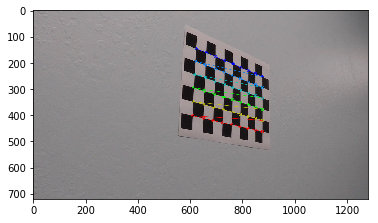

In [2]:
# Specify number of corners
CORNERS_ROW = 9
CORNERS_COL = 6

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((CORNERS_COL*CORNERS_ROW,3), np.float32)
objp[:,:2] = np.mgrid[0:CORNERS_ROW, 0:CORNERS_COL].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/cal*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (CORNERS_ROW,CORNERS_COL), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (CORNERS_ROW,CORNERS_COL), corners, ret)
        plt.imshow(img)


### We now have `objpoints` and `imgpoints` needed for camera calibration.  

Run the cell below to:
1. calibrate
2. calculate distortion coefficients
3. test undistortion on an image

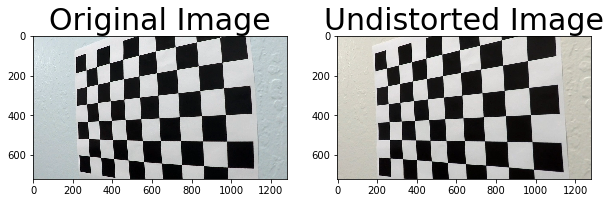

In [3]:
# Test undistortion on an image
img = cv2.imread('camera_cal/calibration4.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('examples/test_undist.jpg',dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump(dist_pickle, open( "camera_cal_dist.p", "wb" ))
dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30);

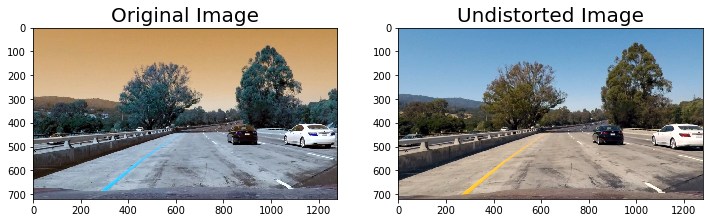

In [4]:
# Test undistortion on a road image
img2 = cv2.imread('test_images/test1.jpg')
img_size2 = (img2.shape[1], img2.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size2,None,None)

dst2 = cv2.undistort(img2, mtx, dist, None, mtx)
cv2.imwrite('examples/test1_undist.jpg',dst2)
dst2 = cv2.cvtColor(dst2, cv2.COLOR_BGR2RGB)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
ax1.imshow(img2)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(dst2)
ax2.set_title('Undistorted Image', fontsize=20);

## Perspective Transform - road image

In [5]:
def plot_images(images, titles, figsize=(10,5)):
    '''Plot image in 1 row
    images: list of images to plot
    titles: list of plot titles
    '''
    num=len(images)
    fig, ax = plt.subplots(1, num, figsize=figsize)
    fig.tight_layout()
    for i in range(num):
        ax[i].imshow(images[i], cmap='gray')
        ax[i].set_title(titles[i], fontsize=20)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [6]:
### Sample coords from road image
# source image
src = np.float32([
        [(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
        [((img_size[0] / 6) - 10), img_size[1]],
        [(img_size[0] * 5 / 6) + 60, img_size[1]],
        [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]
    ])

# destination warped image
dst = np.float32([
        [(img_size[0] / 4), 0],
        [(img_size[0] / 4), img_size[1]],
        [(img_size[0] * 3 / 4), img_size[1]],
        [(img_size[0] * 3 / 4), 0]
    ])

# transorm
M = cv2.getPerspectiveTransform(src, dst)

# inverse transform
Minv = cv2.getPerspectiveTransform(dst, src)

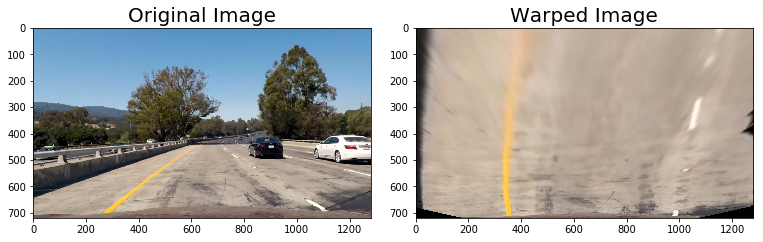

In [7]:
# warp the undistorted road image
warped = cv2.warpPerspective(dst2, M, img_size, flags=cv2.INTER_LINEAR)

# Visualize warping
plot_images([dst2, warped], ['Original Image', 'Warped Image'])

---
# Sobel Operator
The Sobel operator is at the heart of the Canny edge detection algorithm you used in the Introductory Lesson. Applying the Sobel operator to an image is a way of taking the derivative of the image in the x or y direction. 

You need to pass a single color channel to the cv2.Sobel() function, so first convert it to grayscale:

In [8]:
gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
gray = cv2.cvtColor(img2, cv2.COLOR_BGR2HLS)[:,:,2]  # use HLS 3rd channel

Make sure you use the correct grayscale conversion depending on how you've read in your images. 
- Use cv2.COLOR_RGB2GRAY if you've read in an image using mpimg.imread(). 
- Use cv2.COLOR_BGR2GRAY if you've read in an image using cv2.imread().

Calculate the derivative in the x direction (the 1, 0 at the end denotes x direction):



In [9]:
sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
sobelx

array([[   0., -506.,    8., ...,  -22.,  194.,    0.],
       [   0., -260.,  100., ...,   10.,  262.,    0.],
       [   0.,   82.,  195., ...,   10.,  173.,    0.],
       ..., 
       [   0.,   30.,   44., ...,    6.,  -13.,    0.],
       [   0.,    9.,   44., ...,    0.,    6.,    0.],
       [   0.,   -4.,   44., ...,   -4.,   26.,    0.]])

Calculate the derivative in the y direction (the 0, 1 at the end denotes y direction):



In [10]:
sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
sobely

array([[   0.,    0.,    0., ...,    0.,    0.,    0.],
       [-510., -264.,   74., ..., -152.,  -52.,   16.],
       [   2.,   98.,  197., ...,  160.,  -29., -186.],
       ..., 
       [   2.,   -6.,  -14., ...,   -8.,  -11.,  -12.],
       [  14.,    1.,  -12., ...,   10.,   26.,   46.],
       [   0.,    0.,    0., ...,    0.,    0.,    0.]])

In [11]:
# Calculate the absolute value of the x derivative:
abs_sobelx = np.abs(sobelx)

#Convert the absolute value image to 8-bit:
scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

It's not entirely necessary to convert to 8-bit (range from 0 to 255) but in practice, it can be useful in the event that you've written a function to apply a particular threshold, and you want it to work the same on input images of different scales, like jpg vs. png. You could just as well choose a different standard range of values, like 0 to 1 etc.

Create a binary threshold to select pixels based on gradient strength:

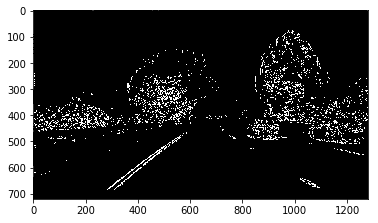

In [12]:
thresh_min = 25
thresh_max = 100
sxbinary = np.zeros_like(scaled_sobel)
sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
plt.imshow(sxbinary, cmap='gray');

## Applying Sobel

In [13]:
# Define a function that takes an image, gradient orientation,
# and threshold min / max values.
def abs_sobel_thresh(img, sobel_kernel=3, orient='x', thresh=(0,255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.abs(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.abs(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    return binary_output

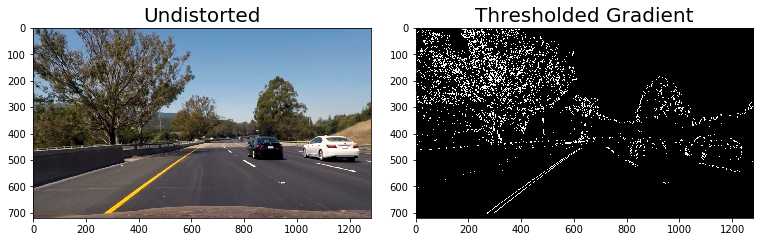

In [14]:
# Read in an image
image = mpimg.imread('./test_images/test6.jpg')

# undistort the image
image = cv2.undistort(image, mtx, dist, None, mtx)

grad_binary = abs_sobel_thresh(image, orient='x', thresh=(35,100))
plot_images([image, grad_binary], ['Undistorted', 'Thresholded Gradient'])

## Magnitude of the Gradient
The magnitude, or absolute value, of the gradient is just the square root of the squares of the individual x and y gradients. For a gradient in both the x and y directions, the magnitude is the square root of the sum of the squares.


abs_sobelxy=√
​(sobel
​x
​​ )
​2
​​ +(sobel
​y
​​ )
​2
​​ 
​
​​ 

In [15]:
# Define a function to return the magnitude of the gradient
# for a given sobel kernel size and threshold values
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output


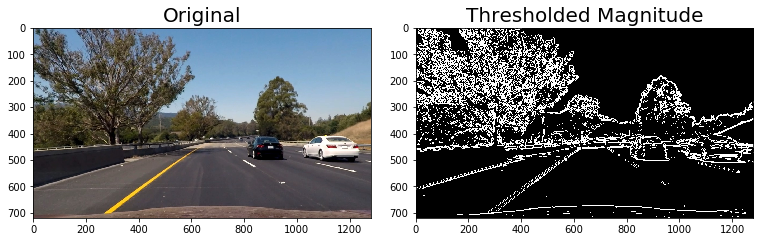

In [16]:
# Run the function
mag_binary = mag_thresh(image, sobel_kernel=9, mag_thresh=(30, 100))

# Plot the result
plot_images([image, mag_binary], ['Original', 'Thresholded Magnitude'])

## Direction of the Gradient
The direction of the gradient is simply the inverse tangent (arctangent) of the y gradient divided by the x gradient:

arctan(sobel
​y
​​ /sobel
​x
​​ ).

- Each pixel of the resulting image contains a value for the angle of gradient away from horizontal in units of radians, covering a range of −π/2 to π/2. 
- An orientation of 0 implies a horizontal line and orientations of +/−π/2 imply vertical lines.


In [17]:
# Define a function to threshold an image for a given range and Sobel kernel
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.abs(sobely), np.abs(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    return binary_output

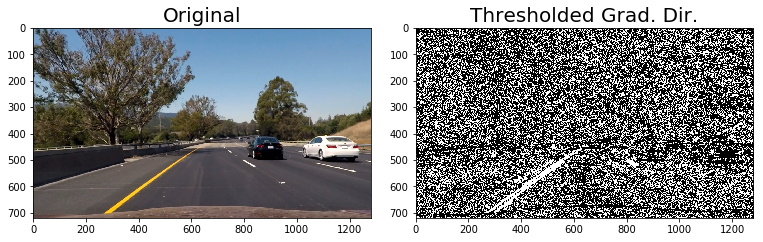

In [18]:
# Run the function
dir_binary = dir_threshold(image, sobel_kernel=9, thresh=(0.7, 1.3))

# Plot the result
plot_images([image, dir_binary], ['Original', 'Thresholded Grad. Dir.'])

## Combining Thresholds
Now consider how you can use various aspects of your gradient measurements (x, y, magnitude, direction) to isolate lane-line pixels. 

Specifically, think about how you can use:
- thresholds of the x and y gradients, 
- the overall gradient magnitude, 
- the gradient direction to focus on pixels that are likely to be part of the lane lines


In [19]:
# Choose a Sobel kernel size
ksize = 3  # Choose a larger odd number to smooth gradient measurements

# Apply each of the thresholding functions
gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(30, 100))
grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(30, 100))
mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(30, 100))
dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0.7, 1.3))

Try different combinations and see what you get.

For example, here is a selection for pixels where both the x and y gradients meet the threshold criteria, or the gradient magnitude and direction are both within their threshold values.

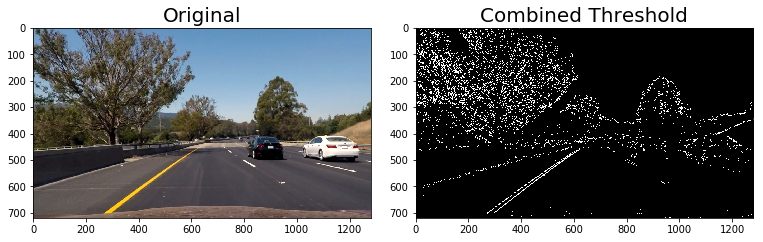

In [20]:
combined = np.zeros_like(dir_binary)
combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

# Plot the result
plot_images([image, combined], ['Original', 'Combined Threshold'])

---


## Color Thresholding


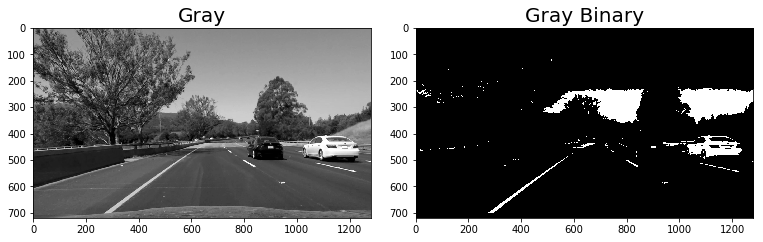

In [21]:
# convert to grayscale, and apply a threshold that identifies the lines:
thresh = (180, 255)
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
binary = np.zeros_like(gray)
binary[(gray > thresh[0]) & (gray <= thresh[1])] = 1

plot_images([gray, binary], ['Gray', 'Gray Binary'])

### HLS Color threshold function

In [22]:
# Define a function that thresholds the S-channel of HLS
def hls_select(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output

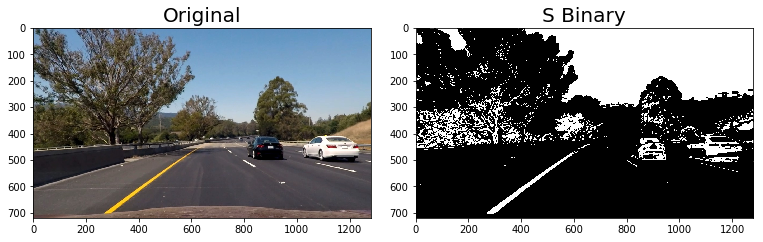

In [23]:
hls_binary = hls_select(image, thresh=(90, 255))
plot_images([image,hls_binary], ['Original','S Binary'])

# Color and Gradient
- see which parts of the lane lines were detected by the gradient threshold and which parts were detected by the color threshold by stacking the channels and seeing the individual components. 
- create a binary combination of these two images to map out where either the color or gradient thresholds were met.

In [24]:
def abs_sobel_thresh(img, sobel_kernel=3, orient='x', thresh=(0,255), convert_gray=False):
    '''Takes an image, gradient orientation, and threshold min/max values.'''
    # Convert to grayscale
    if convert_gray:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    else:
        gray = img.copy()

    # Apply x or y gradient with the OpenCV Sobel() function, take the absolute value
    if orient == 'x':
        abs_sobel = np.abs(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.abs(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    return binary_output


def pipeline(img, s_thresh=(0,255), v_thresh = (0,255), sx_thresh=(0,255)):
    '''Combine Gradient and Color Threshold'''
    img = np.copy(img)
    
    # Convert to HLS color space and separate the S channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    s_channel = hls[:,:,2]
    
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV).astype(np.float)
    v_channel = hsv[:,:,2]
    
    # Sobel x
    sxbinary = abs_sobel_thresh(v_channel, orient='x', thresh=sx_thresh, convert_gray=False)

    # Sobel y, keep static threshold
    sybinary = abs_sobel_thresh(v_channel, orient='y', thresh=(25,255), convert_gray=False)

    # Threshold gradient
    grad_binary = np.zeros_like(s_channel)
    grad_binary[(sxbinary == 1) & (sybinary ==1)] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    v_binary = np.zeros_like(v_channel)
    v_binary[(v_channel >= v_thresh[0]) & (v_channel <= v_thresh[1])] = 1

    c_binary = np.zeros_like(s_channel)
    c_binary[(s_binary == 1) & (v_binary ==1)] = 1
    
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( np.zeros_like(grad_binary), grad_binary, c_binary))
    
    result = np.zeros_like(sxbinary)
    result[(grad_binary == 1) | (c_binary == 1)] = 1

    return result, color_binary
    

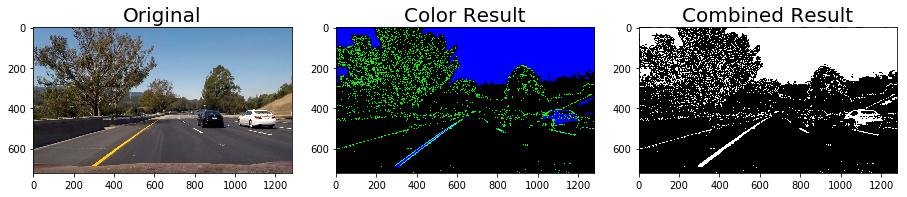

In [25]:
image = mpimg.imread('./test_images/test6.jpg')

# combine the color & gradient threshold
result, color_binary = pipeline(image, s_thresh=(100,255), v_thresh = (100,255), sx_thresh=(12,255))

# Plot the result
plot_images([image, color_binary, result], ['Original', 'Color Result', 'Combined Result'], (12,6))

## Processing each image
### Camera calibrate and undistort
In the project at the end of this module, the first thing you'll do is to compute the camera calibration matrix and distortion coefficients. 

### Thresholding
You'll want to try out various combinations of color and gradient thresholds to generate a binary image where the lane lines are clearly visible.

### Perspective Transform
- identify four source points for your perspective transform. In this case, you can assume the road is a flat plane. 
- The easiest way to do this is to investigate an image where the lane lines are straight, and find four points lying along the lines that, after perspective transform, make the lines look straight and vertical from a bird's eye view perspective.

In [26]:
# work on defining perspective transformation area
img_size = (image.shape[1], image.shape[0])

bot_width = .62  # pct of bottom trapezoid height
mid_width = .08  # pct of middle "         "
height_pct = .63  # pct for trapezoid height
bottom_trim = .935  # pct from top to bottom, avoid car hood

src = np.float32([
        [img_size[0]*(.5-mid_width/2), img_size[1]*height_pct],  # top left
        [img_size[0]*(.5+mid_width/2), img_size[1]*height_pct],  # top right
        [img_size[0]*(.5+bot_width/2), img_size[1]*bottom_trim], # bottom right
        [img_size[0]*(.5-bot_width/2.15), img_size[1]*bottom_trim]  # bottom left
    ])

# destination warped image
offset = img_size[0]*.25
dst = np.float32([
        [offset, 0],                            # top left
        [(img_size[0] - offset), 0],            # top right
        [(img_size[0] - offset), img_size[1]],  # bottom right
        [offset, img_size[1]],                  # bottom left
    ])

# transorm
M = cv2.getPerspectiveTransform(src, dst)

# inverse transform
Minv = cv2.getPerspectiveTransform(dst, src)

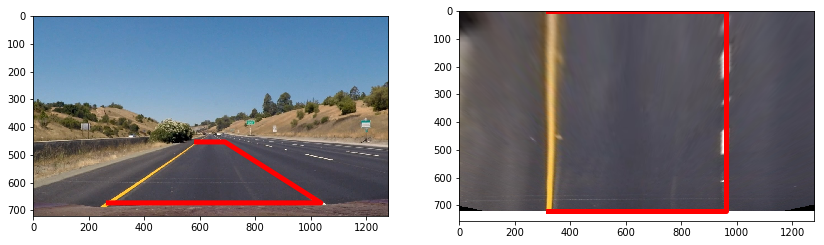

In [27]:
image = mpimg.imread('./test_images/straight_lines1.jpg')

# look at the source image polygon
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.imshow(image)
plt.plot([x[0] for x in src], [x[1] for x in src], 'r-', lw=5);

image_dst = cv2.undistort(image, mtx, dist, None, mtx)
warped = cv2.warpPerspective(image_dst, M, img_size, flags=cv2.INTER_LINEAR)
plt.subplot(1,2,2)
plt.imshow(warped)
plt.plot([x[0] for x in dst], [x[1] for x in dst], 'r-', lw=5);

### Curved lines
- Those same four source points will now work to transform any image (again, under the assumption that the road is flat and the camera perspective hasn't changed). 
- the test of whether the transform is correct is that the lane lines should appear parallel in the warped images, whether they are straight or curved.

./test_images/straight_lines1.jpg


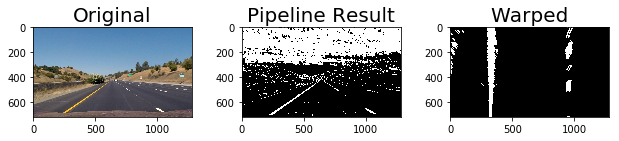

./test_images/straight_lines2.jpg


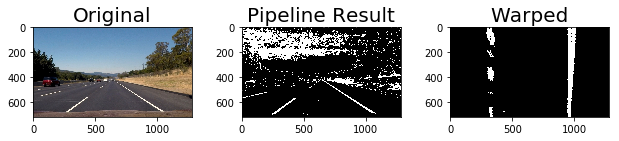

./test_images/test1.jpg


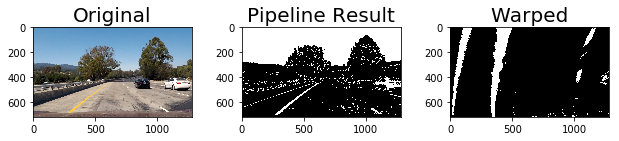

./test_images/test2.jpg


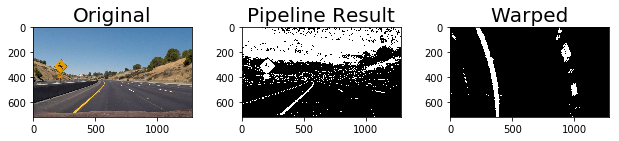

./test_images/test3.jpg


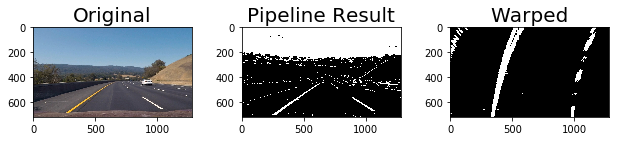

./test_images/test4.jpg


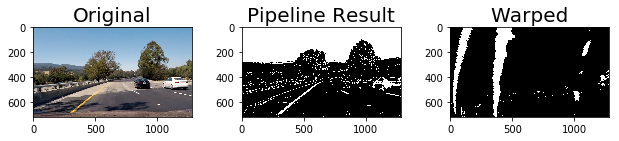

./test_images/test5.jpg


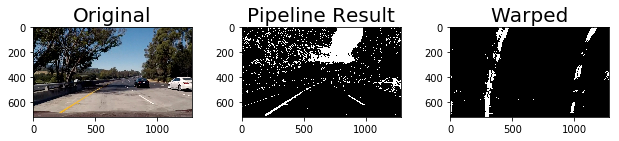

./test_images/test6.jpg


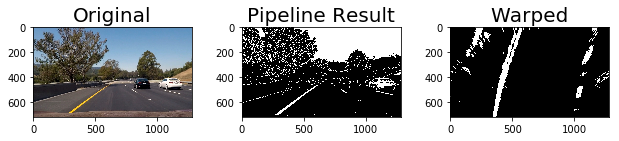

In [28]:
# Look at all test images
for fname in glob.glob('./test_images/*.jpg'):
    image = mpimg.imread(fname)

    # Undistort with camera calibration matrix
    image_dst = cv2.undistort(image, mtx, dist, None, mtx)

    # Generate binary image(s) with pipeline
    result, color_binary = pipeline(image_dst, s_thresh=(100,255), v_thresh = (100,255), sx_thresh=(12,255))

    # Warp the undistorted road image
    warped = cv2.warpPerspective(result, M, img_size, flags=cv2.INTER_LINEAR)

    # Visualize warping
    print(fname)
    plot_images([image, result, warped], ['Original', 'Pipeline Result', 'Warped'], (8,4))
    plt.show()

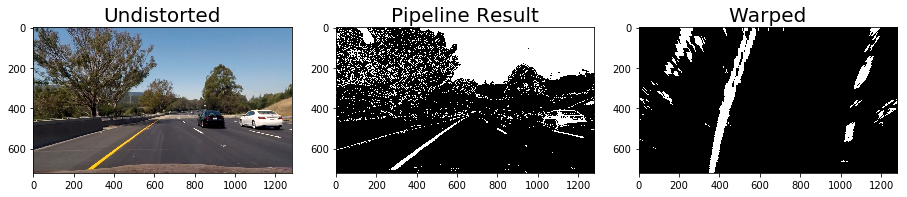

In [29]:
# Look at lane with curved lines
#image = mpimg.imread('./test_images/test6.jpg')
image_dst = cv2.undistort(image, mtx, dist, None, mtx)
result, color_binary = pipeline(image_dst, s_thresh=(100,255), v_thresh = (100,255), sx_thresh=(12,255))

# Warp the undistorted road image
binary_warped = cv2.warpPerspective(result, M, img_size, flags=cv2.INTER_LINEAR)

# Visualize warping
plot_images([image_dst, result, binary_warped], ['Undistorted', 'Pipeline Result', 'Warped'], (12,6))

---
## Locate the Lane Lines and Fit a Polynomial


### Sliding Window
- With this histogram I am adding up the pixel values along each column in the image. 
- In my thresholded binary image, pixels are either 0 or 1, so the two most prominent peaks in this histogram will be good indicators of the x-position of the base of the lane lines.

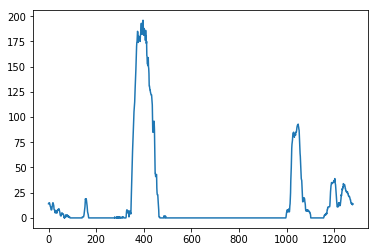

In [30]:
img = binary_warped.copy()
img_shape_y, img_shape_x = img.shape

histogram = np.sum(img[int(img_shape_y/2):,:], axis=0)
plt.plot(histogram);

## Sliding Window Search w/ convolution
- Apply a convolution, which will maximize the number of "hot" pixels in each window
- A convolution is the summation of the product of two separate signals, in our case the window template and the vertical slice of the pixel image.
 
 
- Slide the window template across the image from left to right and any overlapping values are summed together, creating the convolved signal
- The peak of the convolved signal is where there was the highest overlap of pixels and the most likely position for the lane marker.

In [31]:
def window_mask(width, height, img_ref, center,level):
    '''Apply mask to image to '''
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(warped, window_width, window_height, margin):
    '''Run the sliding window search'''
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(warped[int(3*warped.shape[0]/4):,:int(warped.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(warped[int(3*warped.shape[0]/4):,int(warped.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(warped.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(warped.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(warped[int(warped.shape[0]-(level+1)*window_height):int(warped.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,warped.shape[1]))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,warped.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))

    return window_centroids

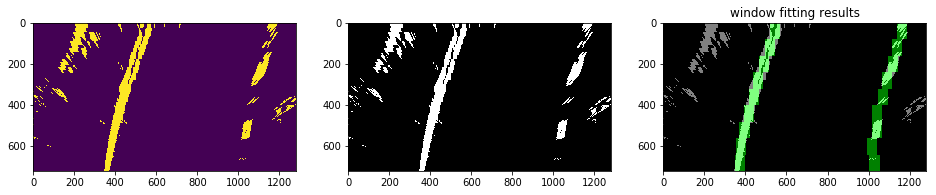

In [32]:
# Read in a thresholded image
warped = 255*binary_warped.copy()

# window settings
window_width = 50 
window_height = 80  # Break image into 9 vertical layers since image height is 720
margin = 100  # How much to slide left and right for searching

window_centroids = find_window_centroids(warped, window_width, window_height, margin)

# If we found any window centers
if len(window_centroids) > 0:
    # Points to find left and right lane lines
    leftx = []
    rightx = []

    # Points used to draw all the left and right windows
    l_points = np.zeros_like(warped)
    r_points = np.zeros_like(warped)

    # Go through each level and draw the windows 
    for level in range(0,len(window_centroids)):
        # add center value found in frame to list of lane points
        leftx.append(window_centroids[level][0])
        rightx.append(window_centroids[level][1])
        # Window_mask is a function to draw window areas
        l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
        r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
        # Add graphic points from window mask here to total pixels found 
        l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
        r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

    # Draw the results
    template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
    zero_channel = np.zeros_like(template) # create a zero color channel
    template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
    warpage = np.array(cv2.merge((warped,warped,warped)),np.uint8) # making the original road pixels 3 color channels
    output = cv2.addWeighted(warpage, 0.5, template, 0.5, 0.0) # overlay the orignal road image with window results

# If no window centers found, just display orginal road image
else:
    output = np.array(cv2.merge((warped,warped,warped)),np.uint8)

# Display the final results
plt.figure(figsize=(16,8))
plt.subplot(1,3,1)
plt.imshow(warped)

plt.subplot(1,3,2)
plt.imshow(warpage)

plt.subplot(1,3,3)
plt.imshow(output)
plt.title('window fitting results');

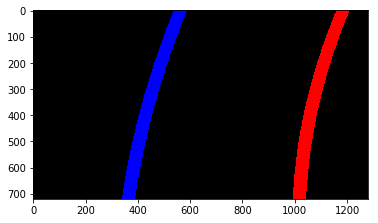

In [33]:
# Fit the lane boundaries to the left & right center positions found
yvals = range(0, warped.shape[0])  # use for extrapolating line in continuous space

# Use box centers' y-values
res_yvals = np.arange(warped.shape[0]-(window_height/2), 0, -window_height)

# Fit a second order polynomial to pixel positions in each fake lane line
left_fit = np.polyfit(res_yvals, leftx, 2)
left_fitx = left_fit[0]*yvals*yvals + left_fit[1]*yvals + left_fit[2]  # create continuous values
left_fitx = np.array(left_fitx, np.int32)

right_fit = np.polyfit(res_yvals, rightx, 2)
right_fitx = right_fit[0]*yvals*yvals + right_fit[1]*yvals + right_fit[2]
right_fitx = np.array(right_fitx, np.int32)

left_lane = np.array(list(zip(np.concatenate((left_fitx - window_width/2, left_fitx[::-1] + window_width/2), axis=0), 
                              np.concatenate((yvals, yvals[::-1]), axis=0))), np.int32)    
right_lane = np.array(list(zip(np.concatenate((right_fitx - window_width/2, right_fitx[::-1] + window_width/2), axis=0), 
                               np.concatenate((yvals, yvals[::-1]), axis=0))), np.int32)

road = np.zeros_like(image)

cv2.fillPoly(road, [left_lane], (0,0,255))  # draw left blue
cv2.fillPoly(road, [right_lane], (255,0,0))  # draw right red
plt.imshow(road);

---
## Measuring Curvature
- You have a thresholded image, where you've estimated which pixels belong to the left and right lane lines
- You've fit a polynomial to those pixel positions
- Next we'll compute the radius of curvature of the fit



### Radius of Curvature
The radius of curvature ([awesome tutorial here](http://www.intmath.com/applications-differentiation/8-radius-curvature.php)) at any point x of the function x=f(y) is given as follows:

R
​curve
​​ =
​∣
​dy
​2
​​ 
​
​d
​2
​​ x
​​ ∣
​
​[1+(
​dy
​
​dx
​​ )
​2
​​ ]
​3/2
​​ 
​​ 

In the case of the second order polynomial above, the first and second derivatives are:

f
​′
​​ (y)=
​dy
​
​dx
​​ =2Ay+B

f
​′′
​​ (y)=
​dy
​2
​​ 
​
​d
​2
​​ x
​​ =2A

So, our equation for radius of curvature becomes:

R
​curve
​​ =
​∣2A∣
​
​(1+(2Ay+B)
​2
​​ )
​3/2
​​ 
​​ 

In [34]:
# Define y-value where we want radius of curvature
# I'll choose the maximum y-value, corresponding to the bottom of the image
y_eval = 720
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])

print(left_curverad, right_curverad)

2892.09524563 1915.32246062


We've calculated the radius of curvature based on pixel values, so the radius we are reporting is in pixel space, which is not the same as real world space. So we actually need to repeat this calculation after converting our x and y values to real world space.


This involves measuring how long and wide the section of lane is that we're projecting in our warped image. We could do this in detail by measuring out the physical lane in the field of view of the camera, but for this project, you can assume that if you're projecting a section of lane similar to the images above, the lane is about 30 meters long and 3.7 meters wide. Or, if you prefer to derive a conversion from pixel space to world space in your own images, compare your images with U.S. regulations that require a minimum lane width of 12 feet or 3.7 meters, and the dashed lane lines are 10 feet or 3 meters long each.

In [35]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720   # meters per pixel in y dimension
xm_per_pix = 3.7/700  # meters per pixel in x dimension

In [36]:
# Fit new polynomials to x,y in world space
curve_fit_cr = np.polyfit(np.array(res_yvals, np.float32)*ym_per_pix, np.array(leftx, np.float32)*xm_per_pix, 2)
right_fit_cr = np.polyfit(np.array(res_yvals, np.float32)*ym_per_pix, np.array(rightx, np.float32)*xm_per_pix, 2)

# Calculate the new radii of curvature
left_curverad = ((1 + (2*curve_fit_cr[0] * yvals[-1]*ym_per_pix + curve_fit_cr[1])**2)**1.5)/np.abs(2*curve_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0] * yvals[-1]*ym_per_pix + right_fit_cr[1])**2)**1.5)/np.abs(2*right_fit_cr[0])

# Now our radius of curvature is in meters
print('{:.2f} m,  {:.2f} m'.format(left_curverad, right_curverad))

920.16 m,  627.40 m


Check out the U.S. government specifications for highway curvature to see how your numbers compare:  http://onlinemanuals.txdot.gov/txdotmanuals/rdw/horizontal_alignment.htm#BGBHGEGC


---
# Tracking of Lane Lines
- Keep track of things like where your last several detections of the lane lines were and what the curvature was, so you can properly treat new detections
- It's useful to define a `Line()` class to keep track of all the interesting parameters
- We also define a `Tracker()` class to detect the lane lines

In [37]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        self.detected = False     # was the line detected in the last iteration?
        self.recent_xfitted = []  # x values of the last n fits of the line
        self.bestx = None         # average x values of the fitted line over the last n iterations
        self.best_fit = None      # polynomial coefficients averaged over the last n iterations
        self.current_fit = [np.array([False])]  # polynomial coefficients for the most recent fit
        self.radius_of_curvature = None  # radius of curvature of the line in some units
        self.deg_per_meter = None        # degrees of curvature per meter (or other units, pixels etc.)
        self.line_base_pos = None        # distance in meters of vehicle center from the line
        self.diffs = np.array([0,0,0], dtype='float')  # diff in fit coefficients between last & new fits
        self.allx = None  # x values for detected line pixels
        self.ally = None  # y values for detected line pixels


# Define a class to track the lane lines
class Tracker():
    def __init__(self, smoothing=15):
        self.recent_centers = deque(maxlen=smoothing)  # store the past center values to smooth the output
        self.window_width = 50 
        self.window_height = 80  # Break image into 9 vertical layers since image height is 720
        self.margin = 25  # How much to slide left and right for searching
        self.ym_per_pix = 30/720   # meters per pixel in vertical axis
        self.xm_per_pix = 3.7/700  # meters per pixel in horizontal axis
        self.smooth_factor = 15  # how many frames to look back for smoothing
        
    def find_window_centroids(self, warped):
        '''Run the sliding window search'''
        window_width = self.window_width
        window_height = self.window_height
        margin = self.margin
        
        window_centroids = [] # Store the (left,right) window centroid positions per level
        window = np.ones(window_width) # Create our window template that we will use for convolutions

        # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
        # and then np.convolve the vertical image slice with the window template 

        # Sum quarter bottom of image to get slice, could use a different ratio
        l_sum = np.sum(warped[int(3*warped.shape[0]/4):,:int(warped.shape[1]/2)], axis=0)
        l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
        r_sum = np.sum(warped[int(3*warped.shape[0]/4):,int(warped.shape[1]/2):], axis=0)
        r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(warped.shape[1]/2)

        # Add what we found for the first layer
        window_centroids.append((l_center,r_center))

        # Go through each layer looking for max pixel locations
        for level in range(1,(int)(warped.shape[0]/window_height)):
            # convolve the window into the vertical slice of the image
            image_layer = np.sum(warped[int(warped.shape[0]-(level+1)*window_height):int(warped.shape[0]-level*window_height),:], axis=0)
            conv_signal = np.convolve(window, image_layer)
            # Find the best left centroid by using past left center as a reference
            # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
            offset = window_width/2
            l_min_index = int(max(l_center+offset-margin,0))
            l_max_index = int(min(l_center+offset+margin,warped.shape[1]))
            l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
            # Find the best right centroid by using past right center as a reference
            r_min_index = int(max(r_center+offset-margin,0))
            r_max_index = int(min(r_center+offset+margin,warped.shape[1]))
            r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
            # Add what we found for that layer
            window_centroids.append((l_center,r_center))
        
        self.recent_centers.append(window_centroids)
        
        #return window_centroids  # return just the current centroids

        return np.average(self.recent_centers, axis=0)  # smooth the markers

### Pipeline described in Q&A
https://www.youtube.com/watch?v=vWY8YUayf9Q&list=PLAwxTw4SYaPkz3HerxrHlu1Seq8ZA7-5P&index=4

In [38]:
# set up class to do line tracking
curve_centers = Tracker()

# search the sliding windows
window_centroids = curve_centers.find_window_centroids(warped)

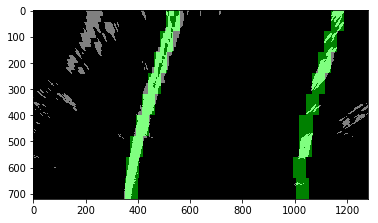

In [39]:
# Points used to draw all the left and right windows
l_points = np.zeros_like(warped)
r_points = np.zeros_like(warped)

# Points to find left and right lane lines
leftx = []
rightx = []

# Go through each level and draw the windows
for level in range(0,len(window_centroids)):
    # add center value found in frame to list of lane points
    leftx.append(window_centroids[level][0])
    rightx.append(window_centroids[level][1])
    
    # Window_mask is a function to draw window areas
    l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
    r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
    # Add graphic points from window mask here to total pixels found 
    l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
    r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255
    
'''Draw the results'''
template = np.array(r_points+l_points,np.uint8)  # add both left and right window pixels together
zero_channel = np.zeros_like(template) # create a zero color channel
template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8)  # make window pixels green
warpage = np.array(cv2.merge((warped,warped,warped)),np.uint8)  # making the original road pixels 3 color channels
result = cv2.addWeighted(warpage, 0.5, template, 0.5, 0.0)  # overlay the orignal road image with window results
plt.imshow(result);


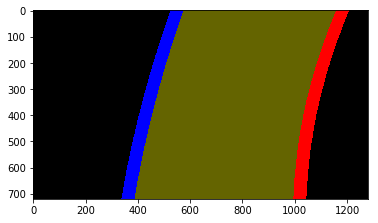

In [40]:
# Fit the lane boundaries to the left & right center positions found
yvals = range(0, warped.shape[0])  # use for extrapolating line in continuous space

# Use box centers' y-values
res_yvals = np.arange(warped.shape[0]-(window_height/2), 0, -window_height)

# Fit a second order polynomial to pixel positions in each fake lane line
left_fit = np.polyfit(res_yvals, leftx, 2)
left_fitx = left_fit[0]*yvals*yvals + left_fit[1]*yvals + left_fit[2]  # create continuous values
left_fitx = np.array(left_fitx, np.int32)

right_fit = np.polyfit(res_yvals, rightx, 2)
right_fitx = right_fit[0]*yvals*yvals + right_fit[1]*yvals + right_fit[2]
right_fitx = np.array(right_fitx, np.int32)

left_lane = np.array(list(zip(np.concatenate((left_fitx - window_width/2, left_fitx[::-1] + window_width/2), axis=0), 
                              np.concatenate((yvals, yvals[::-1]), axis=0))), np.int32)    
right_lane = np.array(list(zip(np.concatenate((right_fitx - window_width/2, right_fitx[::-1] + window_width/2), axis=0), 
                               np.concatenate((yvals, yvals[::-1]), axis=0))), np.int32)
middle_marker = np.array(list(zip(np.concatenate((left_fitx + window_width/2, right_fitx[::-1] - window_width/2), axis=0), 
                                  np.concatenate((yvals, yvals[::-1]), axis=0))), np.int32)

road = np.zeros_like(image)
road_bkg = np.zeros_like(image)

cv2.fillPoly(road, [left_lane], (0,0,255))  # draw left blue
cv2.fillPoly(road, [right_lane], (255,0,0))  # draw right red
cv2.fillPoly(road, [middle_marker], (100,100,0))  # draw middle of lane
cv2.fillPoly(road_bkg, [left_lane], (255,255,255))
cv2.fillPoly(road_bkg, [right_lane], (255,255,255))

plt.imshow(road);

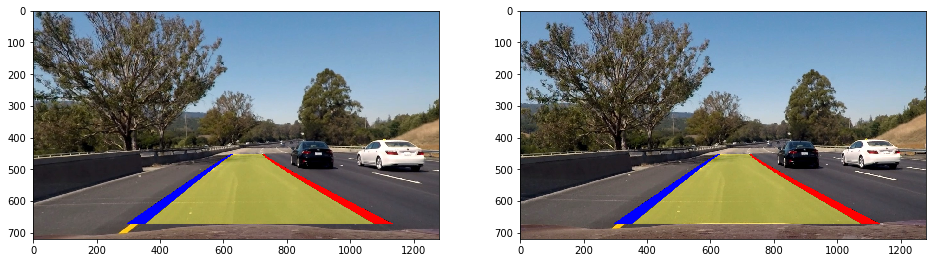

In [41]:
# warp lane lines back to original image
road_warped = cv2.warpPerspective(road, Minv, img_size, flags=cv2.INTER_LINEAR)
road_warped_bkg = cv2.warpPerspective(road_bkg, Minv, img_size, flags=cv2.INTER_LINEAR)

base = cv2.addWeighted(image_dst, 1, road_warped_bkg, -1.0, 0)
result = cv2.addWeighted(base, 1, road_warped, 1.0, 0)

# plot lane lines w/  undistorted image
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.imshow(result)

# plot lane lines w/ original image
base = cv2.addWeighted(image, 1, road_warped_bkg, -1.0, 0)
result = cv2.addWeighted(base, 1, road_warped, 1.0, 0)

plt.subplot(1,2,2)
plt.imshow(result);

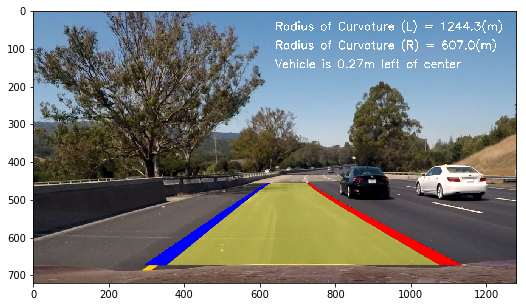

In [42]:
## calculate the radius of curvature
ym_per_pix = curve_centers.ym_per_pix
xm_per_pix = curve_centers.xm_per_pix

# Fit new polynomials to x,y in world space
curve_fit_cr = np.polyfit(np.array(res_yvals, np.float32)*ym_per_pix, np.array(leftx, np.float32)*xm_per_pix, 2)
right_fit_cr = np.polyfit(np.array(res_yvals, np.float32)*ym_per_pix, np.array(rightx, np.float32)*xm_per_pix, 2)

# Calculate the new radii of curvature
curverad = ((1 + (2*curve_fit_cr[0] * yvals[-1]*ym_per_pix + curve_fit_cr[1])**2)**1.5)/np.abs(2*curve_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0] * yvals[-1]*ym_per_pix + right_fit_cr[1])**2)**1.5)/np.abs(2*right_fit_cr[0])

# calculate offset of car on road
camera_center = (left_fitx[-1] + right_fitx[-1]) / 2
center_diff = (camera_center - warped.shape[1]/2) * xm_per_pix
side_pos = 'left'
if center_diff <= 0:
    side_pos = 'right'
    
# draw text: curvature, offset, speed(?)
cv2.putText(result, 'Radius of Curvature (L) = ' + str(round(curverad,1)) + '(m)', (640,50), 
            cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
cv2.putText(result, 'Radius of Curvature (R) = ' + str(round(right_curverad,1)) + '(m)', (640,100), 
            cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
cv2.putText(result,'Vehicle is ' + str(abs(round(center_diff,3))) + 'm ' + side_pos + ' of center', (640,150), 
            cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

plt.figure(figsize=(10,5))
plt.imshow(result);

# Save the results
#write_name = './test_images/tracked' + str(idx) + '.jpg'
#cv2.imwrite(write_name, result)

## Function(s) to process images from video

In [43]:
def gen_binary(image, s_thresh=(100,255), v_thresh = (100,255), sx_thresh=(12,255)):
    '''Combine Gradient and Color Threshold'''
    img = np.copy(image)
    
    # Convert to HLS color space and separate the S channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    s_channel = hls[:,:,2]
    
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV).astype(np.float)
    v_channel = hsv[:,:,2]
    
    # Sobel x
    sxbinary = abs_sobel_thresh(v_channel, orient='x', thresh=sx_thresh, convert_gray=False)

    # Sobel y, keep static threshold
    sybinary = abs_sobel_thresh(v_channel, orient='y', thresh=(25,255), convert_gray=False)

    # Threshold gradient
    grad_binary = np.zeros_like(s_channel)
    grad_binary[(sxbinary == 1) & (sybinary ==1)] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    v_binary = np.zeros_like(v_channel)
    v_binary[(v_channel >= v_thresh[0]) & (v_channel <= v_thresh[1])] = 1

    c_binary = np.zeros_like(s_channel)
    c_binary[(s_binary == 1) & (v_binary ==1)] = 1
    
    result = np.zeros_like(sxbinary)
    result[(grad_binary == 1) | (c_binary == 1)] = 1

    return result
    

In [44]:
def process_image(image):
    '''Pipeline to annotate images with lane lines'''
    window_height = curve_centers.window_height
    window_width = curve_centers.window_width
    
    img = cv2.undistort(image, mtx, dist, None, mtx)
    
    # process image and generate binary pixel of interests
    preprocessImage = gen_binary(img)
    
    # perspective transform
    warped = cv2.warpPerspective(preprocessImage, M, img_size, flags=cv2.INTER_LINEAR)

    # search the sliding windows
    window_centroids = curve_centers.find_window_centroids(warped)

    # Points to find left and right lane lines
    leftx = []
    rightx = []

    # Go through each level of detected windows
    for level in range(0,len(window_centroids)):
        # add center value found in frame to list of lane points
        leftx.append(window_centroids[level][0])
        rightx.append(window_centroids[level][1])
        
    # Fit the lane boundaries to the left & right center positions found
    yvals = range(0, warped.shape[0])  # use for extrapolating line in continuous space

    # Use box centers' y-values
    res_yvals = np.arange(warped.shape[0]-(window_height/2), 0, -window_height)

    # Fit a second order polynomial to pixel positions in each fake lane line
    left_fit = np.polyfit(res_yvals, leftx, 2)
    left_fitx = left_fit[0]*yvals*yvals + left_fit[1]*yvals + left_fit[2]  # create continuous values
    left_fitx = np.array(left_fitx, np.int32)

    right_fit = np.polyfit(res_yvals, rightx, 2)
    right_fitx = right_fit[0]*yvals*yvals + right_fit[1]*yvals + right_fit[2]
    right_fitx = np.array(right_fitx, np.int32)

    left_lane = np.array(list(zip(np.concatenate((left_fitx - window_width/2, left_fitx[::-1] + window_width/2), axis=0), 
                                  np.concatenate((yvals, yvals[::-1]), axis=0))), np.int32)    
    right_lane = np.array(list(zip(np.concatenate((right_fitx - window_width/2, right_fitx[::-1] + window_width/2), axis=0), 
                                   np.concatenate((yvals, yvals[::-1]), axis=0))), np.int32)
    middle_marker = np.array(list(zip(np.concatenate((left_fitx + window_width/2, right_fitx[::-1] - window_width/2), axis=0), 
                                      np.concatenate((yvals, yvals[::-1]), axis=0))), np.int32)

    road = np.zeros_like(img)
    road_bkg = np.zeros_like(img)

    cv2.fillPoly(road, [left_lane], (0,0,255))  # draw left blue
    cv2.fillPoly(road, [right_lane], (255,0,0))  # draw right red
    cv2.fillPoly(road, [middle_marker], (100,100,0))  # draw middle of lane
    cv2.fillPoly(road_bkg, [left_lane], (255,255,255))
    cv2.fillPoly(road_bkg, [right_lane], (255,255,255))    
    
    # warp lane lines back to original image
    road_warped = cv2.warpPerspective(road, Minv, img_size, flags=cv2.INTER_LINEAR)
    road_warped_bkg = cv2.warpPerspective(road_bkg, Minv, img_size, flags=cv2.INTER_LINEAR)

    # plot lane lines w/  undistorted image
    base = cv2.addWeighted(img, 1, road_warped_bkg, -1.0, 0)
    result = cv2.addWeighted(base, 1, road_warped, 1.0, 0)
    
    # calculate the radius of curvature
    ym_per_pix = curve_centers.ym_per_pix
    xm_per_pix = curve_centers.xm_per_pix

    # Fit new polynomials to x,y in world space
    curve_fit_cr = np.polyfit(np.array(res_yvals, np.float32)*ym_per_pix, np.array(leftx, np.float32)*xm_per_pix, 2)
    right_fit_cr = np.polyfit(np.array(res_yvals, np.float32)*ym_per_pix, np.array(rightx, np.float32)*xm_per_pix, 2)

    # Calculate the new radii of curvature
    curverad = ((1 + (2*curve_fit_cr[0] * yvals[-1]*ym_per_pix + curve_fit_cr[1])**2)**1.5)/np.abs(2*curve_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0] * yvals[-1]*ym_per_pix + right_fit_cr[1])**2)**1.5)/np.abs(2*right_fit_cr[0])

    # calculate offset of car on road
    camera_center = (left_fitx[-1] + right_fitx[-1]) / 2
    center_diff = (camera_center - warped.shape[1]/2) * xm_per_pix
    side_pos = 'left'
    if center_diff <= 0:
        side_pos = 'right'

    # draw text: curvature, offset, speed(?)
    cv2.putText(result, 'Radius of Curvature (L) = ' + str(round(curverad,1)) + '(m)', (50,50), 
                cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    cv2.putText(result, 'Radius of Curvature (R) = ' + str(round(right_curverad,1)) + '(m)', (50,100), 
                cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    cv2.putText(result,'Vehicle is ' + str(abs(round(center_diff,3))) + 'm ' + side_pos + ' of center', (50,150), 
                cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

    return result

## Process the test images

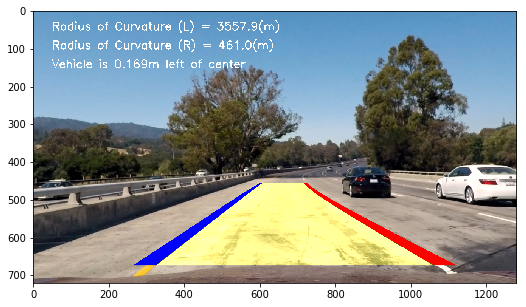

In [45]:
# Read in the saved camera matrix and distortion coefficients
dist_pickle = pickle.load( open( "camera_cal_dist.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

image = mpimg.imread('./test_images/test1.jpg')
curve_centers = Tracker()
result = process_image(image)
plt.figure(figsize=(10,5))
plt.imshow(result);

## Process the video

In [46]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

# Read in the saved camera matrix and distortion coefficients
dist_pickle = pickle.load( open( "camera_cal_dist.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

output_video = 'test_output.mp4'
input_video = '../videos/project_video.mp4'

clip = VideoFileClip(input_video).subclip(25,28)
curve_centers = Tracker()
video_clip = clip.fl_image(process_image)
%time video_clip.write_videofile(output_video, audio=False)

[MoviePy] >>>> Building video test_output.mp4
[MoviePy] Writing video test_output.mp4


 99%|█████████▊| 75/76 [00:25<00:00,  2.32it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_output.mp4 

CPU times: user 21.1 s, sys: 4.83 s, total: 26 s
Wall time: 28.4 s


In [47]:
output_video = 'output_video.mp4'
input_video = '../videos/project_video.mp4'

clip = VideoFileClip(input_video)
curve_centers = Tracker()
video_clip = clip.fl_image(process_image)
video_clip.write_videofile(output_video, audio=False)

[MoviePy] >>>> Building video output_video.mp4
[MoviePy] Writing video output_video.mp4


100%|█████████▉| 1260/1261 [07:02<00:00,  3.75it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_video.mp4 



---
## Process the challenge videos (OPTIONAL)

In [ ]:
output_video = 'output_challenge.mp4'
input_video = '../videos/challenge_video.mp4'

clip = VideoFileClip(input_video)
curve_centers = Tracker()
video_clip = clip.fl_image(process_image)
video_clip.write_videofile(output_video, audio=False)

In [ ]:
output_video = 'output_hard_challenge.mp4'
input_video = '../videos/harder_challenge_video.mp4'

clip = VideoFileClip(input_video).subclip(25,27)
curve_centers = Tracker(smoothing=5)
video_clip = clip.fl_image(process_image)
video_clip.write_videofile(output_video, audio=False)

In [ ]:
output_video = 'output_hwy85.mp4'
input_video = '../videos/highway_85.mp4'

clip = VideoFileClip(input_video).subclip(10,12)
curve_centers = Tracker(2)
video_clip = clip.fl_image(process_image)
video_clip.write_videofile(output_video, audio=False)